# Predicting Bounding Boxes

Welcome to Course 3, Week 1 Programming Assignment! 

In this notebook you'll learn to predict bounding boxes around images. You can treat this as a regression problem by performing transfer learning on any of the pre-trained models available in Keras. In this notebook you'll be using the [Caltech Birds - 2010](http://www.vision.caltech.edu/visipedia/CUB-200.html) dataset. You'll train the model, save it and then later upload it for grading. 

- [0. Imports](#0)
- [1. Visualization Utilities](#1)
  - [1.1 Bounding Boxes Utilities](#1-1)
  - [1.2 Data and Predictions Utilities](#1-2)
  - [Exercise 1](#ex-01)
- [2. Preprocessing and Loading the Dataset](#2)
  - [2.1 Preprocessing Utilities](#2-1)
  - [2.2 Loading the Dataset](#2-2)
  - [2.3 Visualize the prepared Data](#2-3)
- [3. Define the Network](#3)
  - [Exercise 2](#ex-02)
  - [Exercise 3](#ex-03)
  - [Exercise 4](#ex-04)
  - [Exercise 5](#ex-05)
  - [Exercise 6](#ex-06)
- [4. Training the Model](#4)
  - [Exercise 7](#ex-07)
- [5. Validate the Model](#5)
  - [5.1 Loss](#5-1)
  - [5.2 Saving your Model](#5-2)
  - [5.3 Plotting Loss Function](#5-3)  
  - [5.4 Intersection Over Union](#5-4)
- [6. Visualize Predictions](#6)


<a name="0"></a>
## 0. Imports

In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
# If you get a checksum error with the dataset, you'll need this
# !pip install tensorflow-datasets==4.0.1
# !pip install tfds-nightly==4.0.1.dev202010100107

<a name="1"></a>
## 1. Visualization Utilities


<a name="1-1"></a>
### 1.1 Bounding Boxes Utilities

You are provided with some functions which will be used to draw bounding boxes around the birds in the `image`.

In [4]:
# im_width = 224
# im_height = 224

In [3]:
def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image (numpy array).
    
    Args:
      image: a numpy array object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: a list of strings for each bounding box.
    
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """

    draw_bounding_boxes_on_image(image, boxes, color, thickness)
  
    return image

In [4]:
def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image.
    
    Args:
      image: a PIL.Image object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
                           
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
    
    boxes_shape = boxes.shape
    if not boxes_shape:
      return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
      raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
      draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)
      

In [5]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
    """
    Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    
    Args:
      image: a PIL.Image object.
      ymin: ymin of bounding box.
      xmin: xmin of bounding box.
      ymax: ymax of bounding box.
      xmax: xmax of bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
    """
  
    im_width = image.shape[1]
    im_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)


<a name="1-2"></a>
### 1.2 Data and Predictions Utilities

The following utilities are used to visualize the data and predictions. These helper functions are used for visualization and downloads only. You can skip reading them. There is very little useful Keras/Tensorflow code here.

In [6]:
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

In [7]:
# utility to display a row of digits with their predictions
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
  
    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)
    
      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])
    
      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)

In [8]:
# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

<a name='ex-01'></a>
###  Exercise 1

Set the `BATCH_SIZE` to an appropiate value

In [9]:
### START CODE HERE ###

BATCH_SIZE = 64

### END CODE HERE ###

<a name="2"></a>
## 2. Preprocessing and Loading the Dataset

<a name="2-1"></a>
### 2.1 Preprocessing Utilities

This function resizes `image` to (224, 224), normalizes `image` and translates and normalizes bounding boxes.

In [10]:
def read_image_tfds(image, bbox):
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    return image, [bbox[0] / factor_x , bbox[1] / factor_y, bbox[2] / factor_x , bbox[3] / factor_y]

This function reads resized images, bounding boxes and their original shapes.
Resizes `image` to (224, 224), normalizes `image` and translates and normalizes bounding boxes.

In [11]:
def read_image_with_shape(image, bbox):
    original_image = image
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)
    
    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    return original_image, image, [bbox[0] / factor_x , bbox[1] / factor_y, bbox[2] / factor_x , bbox[3] / factor_y]


This function reads `image` from `data` and denormalized bounding boxes

In [12]:
def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)

    return image, [bbox[1] * tf.cast(shape[1], tf.float32) , bbox[0] * tf.cast(shape[0], tf.float32), bbox[3] * tf.cast(shape[1], tf.float32), bbox[2] * tf.cast(shape[0], tf.float32)]

This function converts dataset to numpy arrays of images and boxes.

In [13]:
def dataset_to_numpy_util(dataset, batch_size=0, N=0):

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
      take_dataset = take_dataset.batch(batch_size)
  
    if N > 0:
      take_dataset = take_dataset.take(N)
  
    if tf.executing_eagerly():
      ds_images, ds_bboxes = [], []
      for images, bboxes in take_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        
    return (np.array(ds_images), np.array(ds_bboxes))

This function converts dataset to numpy arrays of original images, resized and normalized images and bounding boxes.

This is used for plotting the original images with true and predicted bounding boxes.

In [14]:
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

  normalized_dataset = dataset.map(read_image_with_shape)
  if batch_size > 0:
    normalized_dataset = normalized_dataset.batch(batch_size)
  
  if N > 0:
    normalized_dataset = normalized_dataset.take(N)

  
  if tf.executing_eagerly():
    ds_original_images, ds_images, ds_bboxes = [], [], []
    for original_images, images, bboxes in normalized_dataset:
      ds_images.append(images.numpy())
      ds_bboxes.append(bboxes.numpy())
      ds_original_images.append(original_images.numpy())

  return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)

<a name="2-2"></a>
### 2.2 Loading the Dataset

This function loads and maps the training split of the dataset. It used map function to reverse the normalization done on the bounding boxes in the dataset.

This will generate the dataset prepared for visualization

In [15]:
def get_visualization_training_dataset():      
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir="/content/drive/My Drive/")
    print(info)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_training_dataset

This function loads and maps the validation split of the dataset. It used map function to reverse the normalization done on the bounding boxes in the dataset.

This will generate the dataset prepared for visualization

In [16]:
def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", try_gcs=True, data_dir="/content/drive/My Drive/")
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset

This function loads and maps the training split of the dataset using the map function for resizing, image normalization and bounding box translation.

In [17]:
def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1) 
    return dataset

This function loads and maps the validation split of the dataset using the map function for resizing, image normalization and bounding box translation.

In [18]:
def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

Now, instantiate the datasets.

In [19]:
visualization_training_dataset = get_visualization_training_dataset()
visualization_validation_dataset = get_visualization_validation_dataset()

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

tfds.core.DatasetInfo(
    name='caltech_birds2010',
    version=0.1.1,
    description='Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
of 200 bird species (mostly North American). The total number of 
categories of birds is 200 and there are 6033 images in the 2010 
dataset and 11,788 images in the 2011 dataset.
Annotations include bounding boxes, segmentation labels.',
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.string),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    }),
    total_num_examples=6033,
    splits={
        'test': 3033,
        'train': 3000,
    },
    supervised_keys=('ima

<a name="2-3"></a>
### 2.3 Visualize the prepared Data
You take a random sample of images from training and validation set and visualize them by plotting the corresponding bounding boxes. You use the visualization datasets you prepared earlier for this purpose.

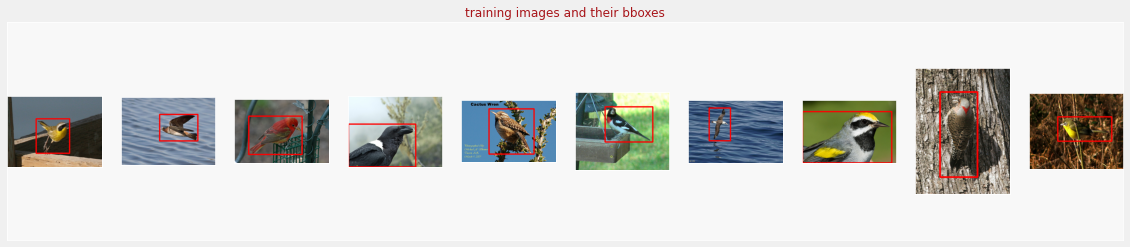

In [20]:
(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their bboxes")


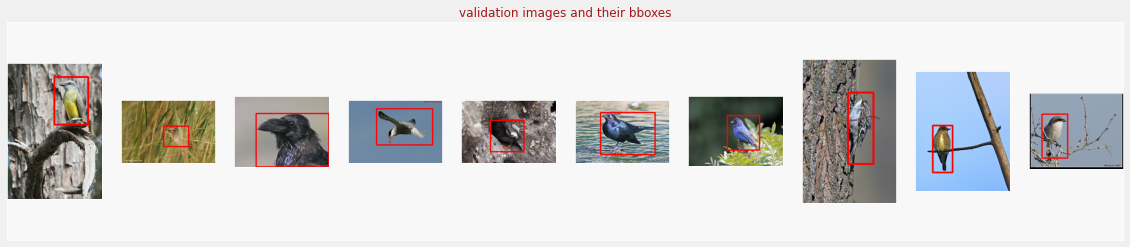

In [21]:
(visualization_validation_images, visualization_validation_bboxes)= dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validation images and their bboxes")


<a name="3"></a>
## 3. Define the Network

Bounding box prediction is treated as a regression problem.

You will be performing transfer learning on **MobileNet V2** available in Keras pretrained models with **imagenet weights** as starting point.
You will opt to retrain all layers of **MobileNet V2** along with the final classification layers.

**Note:** For the following exercises you have to use _Keras Functional API_.

<a name='ex-02'></a>
### Exercise 2

First, you'll build a feature extractor with the help of MobileNetV2 pretrained on imagenet weights. The image input size will be RGB 224 x 224.

Hint: [Keras, using Pre-trained Models](https://keras.rstudio.com/articles/applications.html)

In [22]:
def feature_extractor(inputs):
    ### YOUR CODE HERE ###
    
    # you only need to use initialize `input_shape`, `include_top=False` & `weights` parameters
    resnet_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
    
    ### END CODE HERE ###
    
    feature_extractor = resnet_model(inputs)

    return feature_extractor

<a name='ex-03'></a>
### Exercise 3

Next, you'll define the dense layers to be used by your model.

In [23]:
def dense_layers(inputs): ### Mubsi: dense_layer func
    ### YOUR CODE HERE ###

    # Remmeber, you are building a Functional Model!

    # global average pooling 2D layer.  
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    # flatten layer
    x = tf.keras.layers.Flatten()(x)
    # 1024 Dense layer, with relu
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    # 1024 Dense layer, with relu
    x = tf.keras.layers.Dense(512, activation="relu")(x)

    ### END CODE HERE
    return x

<a name='ex-04'></a>
### Exercise 4


Now you'll build a function for the regression output for bounding box prediction. Remember that we have four units in output layer corresponding to (xmin, ymin, xmax, ymax).

In [24]:
def bounding_box_regression(inputs):
    ### YOUR CODE HERE ###

    # Remmeber, you are building a Functional Model!
    
    # Dense layer named `bounding_box`
    bounding_box_regression_output = tf.keras.layers.Dense(units = '4', name = 'bounding_box')(inputs)

    ### END CODE HERE ###

    return bounding_box_regression_output

<a name='ex-05'></a>
### Exercise 5

Now, you'll add all those functions you have built above into one final model.

In [25]:
def final_model(inputs):
    ### YOUR CODE HERE ###

    # Remmeber, you are building a Functional Model!

    # features
    feature_cnn = feature_extractor(inputs)
    # dense layers
    dense_output = dense_layers(feature_cnn)
    # bounding box
    bounding_box_output = bounding_box_regression(dense_output)
    # define the TensorFlow Keras model using the inputs and outputs to your model
    model = tf.keras.Model(inputs = inputs, outputs =bounding_box_output)

    ### END CODE HERE ###

    return model

<a name='ex-06'></a>
### Exercise 6

Define the final model and compile it. Use Stochastic Gradient Descent as the optimizer with momentum of 0.9 and `mse` as the loss function.

Hint: [Keras, Optimizers](https://keras.io/api/optimizers/)

In [27]:
def define_and_compile_model():
    inputs = tf.keras.layers.Input(shape=(224, 224, 3,))
    model = final_model(inputs)
  
    ### YOUR CODE HERE ###

    model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9), 
              loss ='mse')

    ### END CODE HERE ###

    return model

Run the cell below the define your model and print the model summary.

In [28]:
# define your model
model = define_and_compile_model()
# print model layers
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________

<a name='4'></a>
## 4. Training the Model

Fill in the missing code below and run the code cell. If all goes well your model's training will start.

<a name='ex-07'></a>
### Exercise 7

In [29]:
EPOCHS = 80
steps_per_epoch = 3000//BATCH_SIZE  # 3000 items in this dataset
validation_steps = 3033//BATCH_SIZE

### YOUR CODE HERE ####

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

### END CODE HERE ###

### Mubsi: Model.fit

Epoch 1/80
 2/46 [>.............................] - ETA: 9s - loss: 0.2508WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1648s vs `on_train_batch_end` time: 0.2788s). Check your callbacks.


46/46 [==============================] - 33s 715ms/step - loss: 0.0795 - val_loss: 0.2525
Epoch 2/80
46/46 [==============================] - 33s 718ms/step - loss: 0.0190 - val_loss: 0.2076
Epoch 3/80
46/46 [==============================] - 34s 732ms/step - loss: 0.0128 - val_loss: 0.1898
Epoch 4/80
46/46 [==============================] - 33s 719ms/step - loss: 0.0097 - val_loss: 0.1649
Epoch 5/80
46/46 [==============================] - 33s 722ms/step - loss: 0.0081 - val_loss: 0.1326
Epoch 6/80
46/46 [==============================] - 33s 726ms/step - loss: 0.0069 - val_loss: 0.1150
Epoch 7/80
46/46 [==============================] - 33s 727ms/step - loss: 0.0061 - val_loss: 0.1079
Epoch 8/80
46/46 [==============================] - 34s 737ms/step - loss: 0.0056 - val_loss: 0.0952
Epoch 9/80
46/46 [==============================] - 34s 728ms/step - loss: 0.0050 - val_loss: 0.0821
Epoch 10/80
46/46 [==============================] - 34s 735ms/step - loss: 0.0048 - val_loss: 0.0743


<a name='5'></a>
## 5. Validate the Model

<a name='5-1'></a>
### 5.1 Loss

Lets evaluate the loss value for your trained model.


In [30]:
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

47/47 [==============================] - 12s 260ms/step - loss: 0.0157
Loss:  0.01568532921373844


<a name='5-2'></a>
### 5.2 Saving your Model

Now that you have trained your model and are satisfied with your loss you save your model so you could upload it later for it to be graded.

In [31]:
# You should save your model -- it might be quite large
# Example we used is 34Mb
model.save("birds.h5")

<a name='5-3'></a>
### 5.3 Plot Loss Function

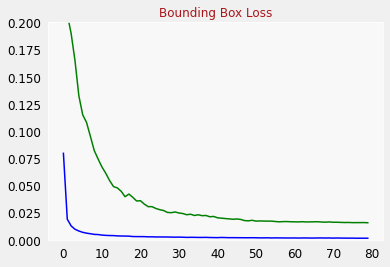

In [32]:
plot_metrics("loss", "Bounding Box Loss", ylim=0.2)


<a name='5-4'></a>
### 5.4 Intersection Over Union

Now you will calculate and get back a list of IoU scores for all the images in the test set.

In [33]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(xmin_pred, xmin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred + 1) * (ymax_pred - ymin_pred + 1)
    true_box_area = (xmax_true - xmin_true + 1) * (ymax_true - ymin_true + 1)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap) + 1,0)  * np.maximum((ymax_overlap - ymin_overlap) + 1, 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    #Updates iou score
    iou = overlap_area / union_area

    return iou



In [34]:
#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=32)


In [35]:
#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.7

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

Number of predictions where iou > threshold(0.7): 340
Number of predictions where iou < threshold(0.7): 160


<a name='6'></a>
## 6. Visualize Predictions

Lastly, you'll plot the predicted and ground truth bounding boxes for a random set of images and visually see how well you did!


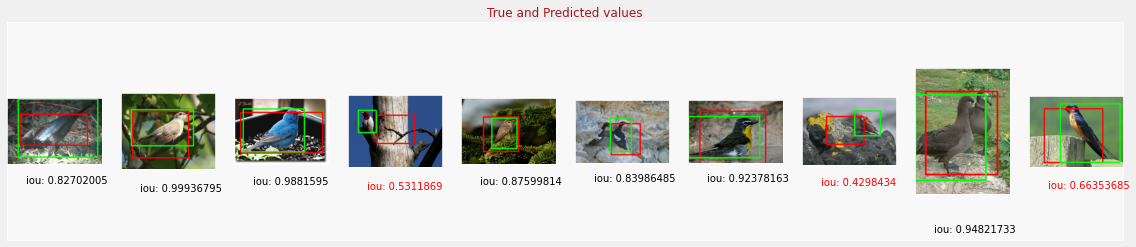

In [36]:
n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)